# Estudo de Caso: deep learning para imagens médicas

1. Importando as bibliotecas:

In [1]:
import numpy as np
import pandas as pd

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical

In [4]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

2. Definindo as propriedades das imagens:

In [5]:
Image_Width=128
Image_Height=128
Image_Size=(Image_Width,Image_Height)
Image_Channels=3

3. Preparando o conjunto de dados para o modelo de treinamento:

In [8]:
filenames=os.listdir('C:\\Users\\jessy\\Downloads\\raio-x-torax\\raio-x-torax\\treino')

In [9]:
categories=[]
for f_name in filenames:
    category=f_name.split('.')[0]
    if category=='pneumonia':
        categories.append(1)
    else:
        categories.append(0)

df=pd.DataFrame({
    'filename':filenames,
    'category':categories
})

df.head(200)

,filename,category
0,normal.0.jpg,0
1,normal.1.jpg,0
2,normal.10.jpg,0
3,normal.11.jpg,0
4,normal.12.jpg,0
...,...,...
195,pneumonia.95.jpeg,1
196,pneumonia.96.jpeg,1
197,pneumonia.97.jpeg,1
198,pneumonia.98.jpeg,1


<AxesSubplot:>

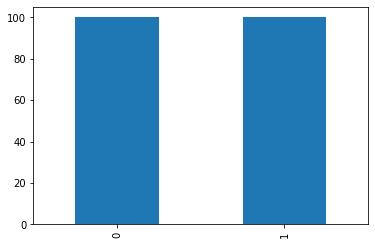

In [10]:
df['category'].value_counts().plot.bar()

4. Criando o modelo da rede neural:

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,\
     Dropout,Flatten,Dense,Activation,BatchNormalization

model=Sequential()

model.add(Conv2D(32,(3,3),activation='relu',input_shape=(Image_Width,Image_Height,Image_Channels)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2,activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=['accuracy'])

5. Analisando o modelo:

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 64)       2

6. Definindo as chamadas de retorno e taxa de aprendizado:

In [38]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience = 10)
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_acc',patience = 2,verbose = 1,factor = 0.1,min_lr = 0.00001)
callbacks = [earlystop,learning_rate_reduction]

7. Gerenciando os dados:

In [39]:
df["category"] = df["category"].replace({0:'normal', 1:'pneumonia'})
train_df,validate_df = train_test_split(df, test_size=0.20, random_state=42)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

total_train=train_df.shape[0]
total_validate=validate_df.shape[0]
batch_size=15

8. Gerando dados de treinamento e validação:

In [40]:
train_datagen = ImageDataGenerator(rotation_range=15,
   rescale=1./255,
   shear_range=0.1,
   zoom_range=0.2,
   horizontal_flip=True,
   width_shift_range=0.1,
   height_shift_range=0.1)

train_generator = train_datagen.flow_from_dataframe(train_df,
   "C:\\Users\\jessy\\Downloads\\raio-x-torax\\raio-x-torax\\treino",
   x_col='filename',
   y_col='category',
   target_size=Image_Size,
   class_mode='categorical',
   batch_size=batch_size)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "C:\\Users\\jessy\\Downloads\\raio-x-torax\\raio-x-torax\\treino", 
    x_col='filename',
    y_col='category',
    target_size=Image_Size,
    class_mode='categorical',
    batch_size=batch_size)

test_datagen = ImageDataGenerator(rotation_range=15,
   rescale=1./255,
   shear_range=0.1,
   zoom_range=0.2,
   horizontal_flip=True,
   width_shift_range=0.1,
   height_shift_range=0.1)


Found 160 validated image filenames belonging to 2 classes.
Found 40 validated image filenames belonging to 2 classes.


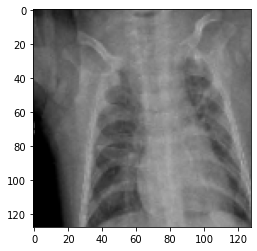

In [17]:
x , y  = train_generator.next()
for i in range(0,1):
    random_image = x[i]
    plt.imshow(random_image)
    plt.show()

9. Treinamento do modelo:

In [41]:
epochs=10
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/10
10/10 [==============================] - 9s 846ms/step - loss: 0.4163 - accuracy: 0.8552 - val_loss: 3.9212 - val_accuracy: 0.4667 - lr: 0.0010
Epoch 2/10
10/10 [==============================] - 8s 792ms/step - loss: 0.5621 - accuracy: 0.8000 - val_loss: 4.1803 - val_accuracy: 0.4333 - lr: 0.0010
Epoch 3/10
10/10 [==============================] - 9s 881ms/step - loss: 0.5184 - accuracy: 0.8069 - val_loss: 5.1415 - val_accuracy: 0.4333 - lr: 0.0010
Epoch 4/10
10/10 [==============================] - 9s 903ms/step - loss: 0.3889 - accuracy: 0.8207 - val_loss: 13.2870 - val_accuracy: 0.3667 - lr: 0.0010
Epoch 5/10
10/10 [==============================] - 9s 855ms/step - loss: 0.4504 - accuracy: 0.8276 - val_loss: 6.4707 - val_accuracy: 0.4333 - lr: 0.0010
Epoch 6/10
10/10 [==============================] - 9s 888ms/step - loss: 0.3768 - accuracy: 0.8966 - val_loss: 10.7010 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 7/10
10/10 [==============================] - 9s 912ms/step - 

10. Salvando o modelo:

In [42]:
model.save("model_raio-x-aula_10epoch.h5")

11. Preparando os dados de teste:

In [43]:
test_filenames = os.listdir("C:\\Users\\jessy\\Downloads\\raio-x-torax\\raio-x-torax\\teste")

test_df = pd.DataFrame({
    'filename': test_filenames
})

test_df

,filename
0,1.jpg
1,10.jpg
2,100.jpg
3,11.jpg
4,12.jpg
...,...
95,95.jpg
96,96.jpg
97,97.jpg
98,98.jpg


12. Testando os dados de treinamento:

In [44]:
test_generator = train_datagen.flow_from_dataframe(test_df,
   'C:\\Users\\jessy\\Downloads\\raio-x-torax\\raio-x-torax\\teste',
   x_col='filename',
   y_col=None,
   target_size=Image_Size,
   class_mode=None,
   batch_size=batch_size)

nb_samples = test_df.shape[0]


Found 100 validated image filenames.


13. Fazendo as previsões das categorias:

In [45]:
predict = model.predict(test_generator, steps=np.ceil(nb_samples/batch_size))

7/7 [==============================] - 2s 316ms/step


14. Convertendo os labels em categorias:

In [46]:
test_df['category'] = np.argmax(predict, axis=-1)

label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

test_df['category'] = test_df['category'].replace({ 'pneumonia': 1, 'normal': 0 })

15. Visualizando os resultados da previsão:

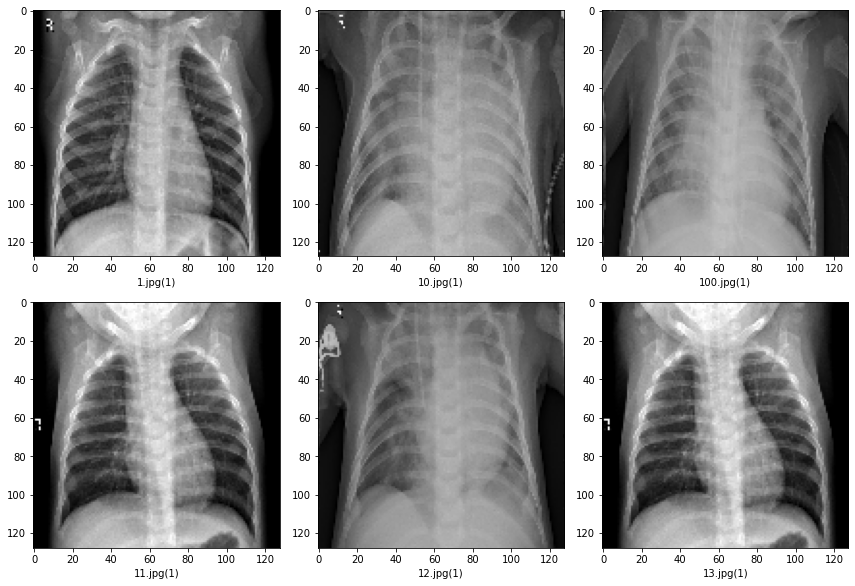

In [47]:
sample_test = test_df.head(6)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("C:\\Users\\jessy\\Downloads\\raio-x-torax\\raio-x-torax\\teste\\"+filename, target_size=Image_Size)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

16. Testando o desempenho do modelo em dados personalizados:

1/1 [==============================] - 0s 43ms/step
[9.9999833e-01 1.6096182e-06]
Diagnóstico indicado: RX normal


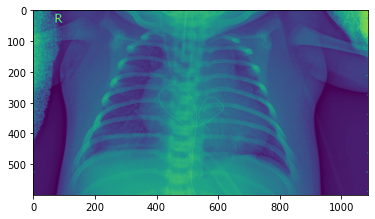

In [48]:
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow import keras
import cv2

im=Image.open("C:\\Users\\jessy\\Downloads\\raio-x-torax\\raio-x-torax\\teste\\98.jpg")
img=im
im=im.resize(Image_Size)
im=(np.random.standard_normal([128,128,3])*255)
im=np.expand_dims(im,axis=0)
im=np.array(im)
im=im/255
pred=model.predict([im])[0]

print(pred)

if pred[0] > pred[1]:
    print ('Diagnóstico indicado: RX normal')
else:
    print('Diagnóstico indicado: RX pneumonia')

plt.imshow(img)
plt.show()

# Classificador GUI para imagens médicas

1. Gerando a GUI:

In [51]:
import tkinter as tk
from tkinter import filedialog
from tkinter import *
from PIL import ImageTk, Image
import numpy
import os

from keras.models import load_model
model = load_model('model_raio-x-aula_10epoch.h5')

#initialise GUI
top=tk.Tk()
top.geometry('800x600')
top.title('Classificação para raio-x de tórax')
top.configure(background='#CDCDCD')
label=Label(top,background='#CDCDCD', font=('arial',15,'bold'))
sign_image = Label(top)
def classify(file_path):
    global label_packed
    image = Image.open(file_path)
    image = (np.random.standard_normal([128,128,3])*255)
    image = numpy.expand_dims(image, axis=0)
    image = numpy.array(image)
    image = image/255
    pred = model.predict([image])[0]
    basename = os.path.basename(file_path)

    if pred[0] > pred[1]:
        sign ='Diagnóstico indicado: RX normal'
    else:
        sign = 'Diagnóstico indicado: RX pneumonia'
    print(sign)
    label.configure(foreground='#011638', text=f'{sign} {str(max(pred*100))} {str("%")}')  

def show_classify_button(file_path):
    classify_b=Button(top,text="Classificar imagem",
   command=lambda: classify(file_path),
   padx=10,pady=5)
    classify_b.configure(background='#364156', foreground='white',
font=('arial',10,'bold'))
    classify_b.place(relx=0.79,rely=0.46)

def upload_image():
    try:
        file_path=filedialog.askopenfilename()
        uploaded=Image.open(file_path)
        uploaded.thumbnail(((top.winfo_width()/2.25),
    (top.winfo_height()/2.25)))
        im=ImageTk.PhotoImage(uploaded)
        sign_image.configure(image=im)
        sign_image.image=im
        label.configure(text='')
        show_classify_button(file_path)
    
    except:
        pass
upload=Button(top,text="Upload da imagem",command=upload_image,padx=10,pady=5)
upload.configure(background='#364156', foreground='white',font=('arial',10,'bold'))
upload.pack(side=BOTTOM,pady=50)
sign_image.pack(side=BOTTOM,expand=True)
label.pack(side=BOTTOM,expand=True)
heading = Label(top, text="Classificação para raio-x de tórax",pady=20, font=('arial',20,'bold'))
heading.configure(background='#CDCDCD',foreground='#364156')
heading.pack()
top.mainloop()

1/1 [==============================] - 0s 112ms/step
Diagnóstico indicado: RX normal
1/1 [==============================] - 0s 46ms/step
Diagnóstico indicado: RX normal
